In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import random


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image


2023-05-17 13:43:10.575765: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 13:43:10.870797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 13:43:11.818638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
attribute_path = "/home/q384e672/Documents/Celeba/list_attr_celeba.csv" 
eval_path = "/home/q384e672/Documents/Celeba/list_eval_partition.csv"
images_path = "/home/q384e672/Documents/Celeba/img_align_celeba/img_align_celeba/"
attr_df = pd.read_csv(attribute_path, index_col= 'image_id')
eval_df = pd.read_csv(eval_path, index_col = 'image_id')
attr_df.replace(to_replace = -1, value = 0, inplace = True)
data_df =  pd.merge(attr_df["Male"], eval_df, left_on = 'image_id', right_on='image_id')

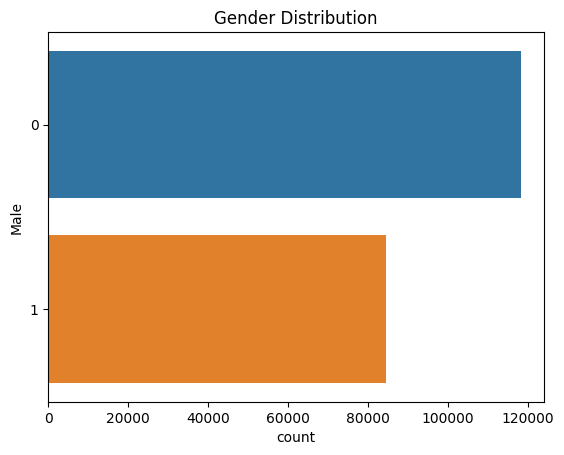

In [4]:
plt.title("Gender Distribution")
sns.countplot(y = 'Male', data = attr_df)
plt.show()


In [5]:
img_size = (224, 224)
batch_size = 32

In [6]:
def create_data_artifacts(training_size ,validation_size, testing_size):
    
    # Training Data
    train_df = data_df[data_df["partition"] == 0].drop('partition', axis = 1)
    male_df = train_df[train_df['Male'] == 1]
    female_df = train_df[train_df['Male'] == 0]

    male_samples = male_df.sample(training_size // 2)
    female_samples = female_df.sample(training_size // 2)

    train_df = pd.concat([male_samples, female_samples])

    # Validation Data
    valid_df = data_df[data_df["partition"] == 1].drop('partition', axis = 1)
    male_df = valid_df[valid_df['Male'] == 1]
    female_df = valid_df[valid_df['Male'] == 0]

    male_samples = male_df.sample(validation_size // 2)
    female_samples = female_df.sample(validation_size // 2)

    valid_df = pd.concat([male_samples, female_samples])

    # Testing Data
    test_df = data_df[data_df["partition"] == 2].drop('partition', axis = 1)
    male_df = test_df[test_df['Male'] == 1]
    female_df = test_df[test_df['Male'] == 0]

    male_samples = male_df.sample(testing_size // 2)
    female_samples = female_df.sample(testing_size // 2)

    test_df = pd.concat([male_samples, female_samples])
    
    # Training Data
    predict_train_images = []
    train_images = []
    train_labels = []

    for index, row in train_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        train_images.append(image)
        train_labels.append(row["Male"])
        image = np.reshape(image, (1, 224, 224, 3))
        predict_train_images.append(image)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    # Validation Data

    valid_images = []
    valid_labels = []

    for index, row in valid_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        valid_images.append(image)
        valid_labels.append(row["Male"])

    valid_images = np.array(valid_images)
    valid_labels = np.array(valid_labels)

    # Testing Data

    test_images = []
    test_labels = []

    for index, row in test_df.iterrows():
        image_path = os.path.join(images_path + row.name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, img_size)
        image = np.array(image, dtype = np.float32) / 255.0
        test_images.append(image)
        test_labels.append(row["Male"])

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, valid_images, valid_labels, test_images, test_labels, predict_train_images


In [7]:
def custom_loss(y_true, y_pred, mse):
    alpha = 1
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + alpha * mse

In [8]:
def create_algorithm_model(x_model, mse):
    for layer in x_model.layers:
        layer.trainable = False

    #Add new classifier layers on top of the ResNet50 base layers
    x = Flatten()(x_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = x_model.input, outputs = x)
    model.compile(loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, mse), optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# Defines a model with the modified architecture
def create_model(x_model):
    for layer in x_model.layers:
        layer.trainable = False

    #Add new classifier layers on top of the ResNet50 base layers
    x = Flatten()(x_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    # x = x_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # predicitions = Dense(1, activation='softmax')(x)
        
    model = Model(inputs = x_model.input, outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
    return model 

In [10]:
# Trains the model on the Dataset and prints the accuracy
def FineTune(model, train_images, train_labels, val_images, val_labels, test_images, test_labels, batch_size, file_name):
    history = model.fit(
        train_images,
        train_labels,
        batch_size = batch_size,
        steps_per_epoch = len(train_images) // batch_size,
        validation_data = (val_images, val_labels),
        epochs = 5,
        callbacks=[EarlyStopping(patience=3), ModelCheckpoint('temp.h5', save_best_only=True)]
    )
    
    scores = model.evaluate(test_images, test_labels)
    print("Test Loss:", scores[0])
    print("Test Accuracy:", scores[1])
    
    if file_name != "no":
        model.save_weights("models/" + file_name)
    return model

In [11]:
def find_confident_samples(model, predict_train_images, train_images):
    confident_images = []
    confident_labels = []
    for index, image in enumerate(predict_train_images):
        prediction = model.predict(image)
        if prediction < 0.1 or prediction > 0.9:
            confident_images.append(train_images[index])
            if prediction < 0.1:
                confident_labels.append(0)
            else:
                confident_labels.append(1)
    print(len(confident_labels))

    confident_images = np.array(confident_images)
    confident_labels = np.array(confident_labels)
    return confident_images, confident_labels

In [12]:
pertubations = ["color-jitter", "horizontal-flippping"]

def pertubate(image_path):

    img = cv2.imread(image_path)
    order = random.randint(0, 1)
    if order == 0:
        # Define the random color jitter parameters
        brightness = np.random.randint(-30, 30)
        contrast = np.random.uniform(0.5, 1.5)
        saturation = np.random.uniform(0.5, 1.5)
        hue = np.random.randint(-10, 10)

        # Convert image to HSV color space
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Apply brightness, contrast, and saturation adjustments to the image
        img_hsv[:,:,2] = cv2.addWeighted(img_hsv[:,:,2], contrast, 0, brightness, 0)
        img_hsv[:,:,1] = cv2.addWeighted(img_hsv[:,:,1], saturation, 0, 0, 0)

        # Convert the image back to BGR color space
        jittered_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
        
        return jittered_img
    
    if order == 1:
        flipped_img = np.fliplr(img)
        return flipped_img

In [13]:
def pick_generalizable_images(generalizable_size):
    # Generalizable Data 
    generalizable_df = data_df.sample(generalizable_size).drop('partition', axis = 1)
    
    original_images = []
    pertubated_images = []
    
    for index, row in generalizable_df.iterrows():
        try:
            image_path = os.path.join(images_path + row.name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, img_size)
            image = np.array(image, dtype = np.float32) / 255.0
            image = np.reshape(image, (1, 224, 224, 3))
            original_images.append(image)
            
            pertubated_image = pertubate(image_path)
            pertubated_image = cv2.resize(pertubated_image, img_size)
            pertubated_image = np.array(pertubated_image, dtype = np.float32) / 255.0
            pertubated_image = np.reshape(pertubated_image, (1, 224, 224, 3))
            pertubated_images.append(pertubated_image)
        except Exception as err:
            print("Failed at Index", index, " Erros is:", err)
        
    return original_images, pertubated_images


In [14]:
def calculate_mse(model, generalizable_size):
    
    original_images, pertubated_images = pick_generalizable_images(generalizable_size)
    mean_square_error = 0
    
    for index, original_image in enumerate(original_images):
        pertubated_image = pertubated_images[index]
        original_prediction = model.predict(original_image)
        pertubated_prediction = model.predict(pertubated_image)
        if (original_prediction > 0.5 and pertubated_prediction > 0.5) or (original_prediction < 0.5 and pertubated_prediction < 0.5):
            mean_square_error += 0
        else:
            
            mean_square_error += 1
            mean_square_error = mean_square_error / generalizable_size
        return mean_square_error
            


In [15]:
labelled_training_samples = [100, 200, 500, 1000]
cotrainteach_sample = 200
num_iterations_alg = 4
total_sample_size = len(data_df)


In [16]:
for i in range(len(labelled_training_samples)):    
    labelled_data_size = labelled_training_samples[i]
    print("Training on Labelled Size:", labelled_data_size)
    # Initial Training
    training_size = labelled_data_size
    validation_size = training_size // 3
    testing_size = training_size // 3 
    train_images, train_labels, valid_images, valid_labels, test_images, test_labels, pretrained_images = create_data_artifacts(training_size, validation_size, testing_size)
    train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, pretrained_images1 = create_data_artifacts(training_size, validation_size, testing_size)
    
    
    vgg1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    vgg1 = create_model(vgg1)
    vgg2 = create_model(vgg2)
    
    filename1 = str(training_size) + "_vgg1_fine_tuned.h5"
    filename2 = str(training_size) + "_vgg2_fine_tuned.h5"
    
    vgg1 = FineTune(vgg1, train_images, train_labels, valid_images, valid_labels, test_images, test_labels, batch_size, filename1)
    vgg2 = FineTune(vgg1, train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, filename2)
    
    print("Model Weights for Initial Training saved for Labelled size : ", labelled_data_size)
    
    generalizable_size = total_sample_size - labelled_data_size
    
    print("Calculating Mean Square Error Losses")
    vgg1_mse = calculate_mse(vgg1, generalizable_size)
    vgg2_mse = calculate_mse(vgg2, generalizable_size)
    
    training_size = cotrainteach_sample
    validation_size = training_size // 3
    testing_size = training_size // 3
        
    vgg1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    vgg1 = create_algorithm_model(vgg1, vgg1_mse)
    vgg2 = create_algorithm_model(vgg2, vgg2_mse)

    vgg1.load_weights('models/' + filename1)
    vgg2.load_weights('models/' + filename2)
    
    print("Consistency Regularization Loss Computed")
    
    # Algorithm Training
    for j in range(num_iterations_alg):
        
        print("Algorithm Iteration :", j+1)

        # Unsupervised Part - A 
        train_images1, train_labels1, valid_images1, valid_labels1, test_images1, test_labels1, predict_train_images1 = create_data_artifacts(training_size, validation_size, testing_size)
        train_images2, train_labels2, valid_images2, valid_labels2, test_images2, test_labels2, predict_train_images2 = create_data_artifacts(training_size, validation_size, testing_size)
        
        print("Finding Confident Samples")
        vgg1_confident_images, vgg1_confident_labels = find_confident_samples(vgg1, predict_train_images1, train_images1)
        vgg2_confident_images, vgg2_confident_labels = find_confident_samples(vgg2, predict_train_images2, train_images2)
        
        if j % 2 == 1:
        # Co- Training
            print("Performing Co- Training")
            vgg1 = FineTune(vgg1, vgg1_confident_images, vgg1_confident_labels, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, "no")
            vgg2 = FineTune(vgg2, vgg2_confident_images, vgg2_confident_labels, valid_images2, valid_labels2, test_images2, test_labels2, batch_size, "no")
        else:
            # Co - Teaching
            print("Performing Co- Teaching")
            vgg1 = FineTune(vgg1, vgg2_confident_images, vgg2_confident_labels, valid_images2, valid_labels2, test_images2, test_labels2, batch_size, "no")
            vgg2 = FineTune(vgg2, vgg1_confident_images, vgg1_confident_labels, valid_images1, valid_labels1, test_images1, test_labels1, batch_size, "no")
    
    filename1  = str(training_size) + "_vgg1_algorithm.h5"
    filename2  = str(training_size) + "_vgg2_algorithm.h5"
    
    vgg1.save_weights("models/" + filename1)
    vgg2.save_weights("models/" + filename2)
    
    print("Model Weights for Algorithm saved for Labelled size : ", labelled_data_size)
        

Training on Labelled Size: 100


2023-05-17 13:43:28.139957: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5
3/3 [==============================] - 5s 2s/step - loss: 4.6809 - accuracy: 0.5417 - val_loss: 4.8576 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 0.9965 - accuracy: 0.8088 - val_loss: 2.8226 - val_accuracy: 0.6562
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.0923 - accuracy: 0.7647 - val_loss: 1.0031 - val_accuracy: 0.7812
Epoch 4/5
3/3 [==============================] - 2s 669ms/step - loss: 0.6543 - accuracy: 0.8676 - val_loss: 1.4286 - val_accuracy: 0.7500
Epoch 5/5
1/1 [==============================] - 1s 602ms/step - loss: 2.7405 - accuracy: 0.6562
Test Loss: 2.74045467376709
Test Accuracy: 0.65625
Epoch 1/5
3/3 [==============================] - 4s 2s/step - loss: 1.1965 - accuracy: 0.7708 - val_loss: 1.0077 - val_accuracy: 0.7500
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 0.7885 - accuracy: 0.8088 - val_loss: 0.6632 - val_accuracy: 0.7188
Epoch 3/5
3/3 [==================

1/1 [==============================] - 0s 50ms/step
185
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
173
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 3.1921 - accuracy: 0.6187 - val_loss: 3.5840 - val_accuracy: 0.6818
Epoch 2/5
5/5 [==============================] - 4s 919ms/step - loss: 1.1044 - accuracy: 0.8156 - val_loss: 3.6936 - val_accuracy: 0.6364
Epoch 3/5
5/5 [==============================] - 5s 1s/step - loss: 0.4487 - accuracy: 0.9362 - val_loss: 1.2085 - val_accuracy: 0.7576
Epoch 4/5
5/5 [==============================] - 4s 836ms/step - loss: 0.2748 - accuracy: 0.9362 - val_loss: 1.4626 - val_accuracy: 0.7879
Epoch 5/5
3/3 [==============================] - 1s 316ms/step - loss: 1.0132 - accuracy: 0.8939
Test Loss: 1.0132092237472534
Test Accuracy: 0.8939393758773804
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 1.7533 - accuracy: 0.7812 - val_loss: 3.0360 - val_accuracy: 0.6515
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.485

Finding Confident Samples
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 50ms/step
183
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 55ms/step
186
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0669 - accuracy: 0.9875 - val_loss: 1.9085 - val_accuracy: 0.7273
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0631 - accuracy: 0.9669 - val_loss: 1.5558 - val_accuracy: 0.7879
Epoch 3/5
5/5 [==============================] - 5s 1s/step - loss: 0.0426 - accuracy: 0.9868 - val_loss: 1.4900 - val_accuracy: 0.7576
Epoch 4/5
5/5 [==============================] - 4s 895ms/step - loss: 0.0425 - accuracy: 0.9868 - val_loss: 1.6356 - val_accuracy: 0.7727
Epoch 5/5
3/3 [==============================] - 1s 317ms/step - loss: 1.6522 - accuracy: 0.7879
Test Loss: 1.6521848440170288
Test Accuracy: 0.7878788113594055
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0218 - accuracy: 0.9875 - val_loss: 1.5950 - val_accuracy: 0.8182
Epoch 2/5
5/5 [==============================] - 4s 927ms/step - loss: 0.034

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step
188
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
193
Performing Co- Teaching
Epoch 1/5
6/6 [==============================] - 6s 1s/step - loss: 0.7166 - accuracy: 0.8646 - val_loss: 6.2083 - val_accuracy: 0.5606
Epoch 2/5
6/6 [==============================] - 5s 1s/step - loss: 0.4902 - accuracy: 0.9068 - val_loss: 2.1372 - val_accuracy: 0.7576
Epoch 3/5
6/6 [==============================] - 5s 957ms/step - loss: 0.2742 - accuracy: 0.9379 - val_loss: 1.3957 - val_accuracy: 0.8030
Epoch 4/5
6/6 [==============================] - 4s 747ms/step - loss: 0.1476 - accuracy: 0.9627 - val_loss: 5.2197 - val_accuracy: 0.6515
Epoch 5/5
3/3 [==============================] - 1s 316ms/step - loss: 3.4295 - accuracy: 0.6818
Test Loss: 3.429485321044922
Test Accuracy: 0.6818181872367859
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 1.7864 - accuracy: 0.7750 - val_loss: 3.0203 - val_accuracy: 0.6515
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.7244

1/1 [==============================] - 0s 51ms/step
189
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step
185
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0424 - accuracy: 0.9875 - val_loss: 6.5753 - val_accuracy: 0.6212
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0560 - accuracy: 0.9745 - val_loss: 6.0948 - val_accuracy: 0.6212
Epoch 3/5
5/5 [==============================] - 4s 900ms/step - loss: 0.0230 - accuracy: 0.9873 - val_loss: 6.6028 - val_accuracy: 0.6212
Epoch 4/5
5/5 [==============================] - 4s 911ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 6.5856 - val_accuracy: 0.6212
Epoch 5/5
3/3 [==============================] - 1s 316ms/step - loss: 3.4699 - accuracy: 0.7121
Test Loss: 3.469877243041992
Test Accuracy: 0.7121211886405945
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 0.1045 - accuracy: 0.9625 - val_loss: 0.7124 - val_accuracy: 0.8636
Epoch 2/5
5/5 [==============================] - 4s 939ms/step - loss: 0.0

1/1 [==============================] - 0s 52ms/step
158
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step
154
Performing Co- Teaching
Epoch 1/5
4/4 [==============================] - 6s 2s/step - loss: 0.5506 - accuracy: 0.8672 - val_loss: 1.6024 - val_accuracy: 0.7424
Epoch 2/5
4/4 [==============================] - 5s 1s/step - loss: 0.1922 - accuracy: 0.9344 - val_loss: 0.3507 - val_accuracy: 0.8939
Epoch 3/5
4/4 [==============================] - 4s 990ms/step - loss: 0.2549 - accuracy: 0.9426 - val_loss: 0.8069 - val_accuracy: 0.8485
Epoch 4/5
4/4 [==============================] - 4s 1s/step - loss: 0.2296 - accuracy: 0.9508 - val_loss: 1.3156 - val_accuracy: 0.8182
Epoch 5/5
3/3 [==============================] - 1s 316ms/step - loss: 1.4734 - accuracy: 0.7879
Test Loss: 1.473422884941101
Test Accuracy: 0.7878788113594055
Epoch 1/5
4/4 [==============================] - 6s 1s/step - loss: 0.7224 - accuracy: 0.8281 - val_loss: 0.7610 - val_accuracy: 0.7424
Epoch 2/5
4/4 [==============================] - 4s 1s/step - loss: 0.2070 - 

1/1 [==============================] - 0s 50ms/step
184
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step
177
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.1098 - accuracy: 0.9625 - val_loss: 0.7840 - val_accuracy: 0.8485
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0633 - accuracy: 0.9671 - val_loss: 0.7444 - val_accuracy: 0.8788
Epoch 3/5
5/5 [==============================] - 4s 894ms/step - loss: 0.0577 - accuracy: 0.9671 - val_loss: 0.7566 - val_accuracy: 0.8636
Epoch 4/5
5/5 [==============================] - 4s 871ms/step - loss: 0.0828 - accuracy: 0.9803 - val_loss: 0.7553 - val_accuracy: 0.8636
Epoch 5/5
3/3 [==============================] - 1s 307ms/step - loss: 0.7545 - accuracy: 0.8788
Test Loss: 0.7545208930969238
Test Accuracy: 0.8787878751754761
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.1099 - accuracy: 0.9438 - val_loss: 0.7682 - val_accuracy: 0.8788
Epoch 2/5
5/5 [==============================] - 4s 926ms/step - loss: 0.

Finding Confident Samples
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 58ms/step
183
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step
184
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0827 - accuracy: 0.9625 - val_loss: 0.7283 - val_accuracy: 0.8636
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.1444 - accuracy: 0.9408 - val_loss: 0.4945 - val_accuracy: 0.8182
Epoch 3/5
5/5 [==============================] - 4s 892ms/step - loss: 0.1100 - accuracy: 0.9605 - val_loss: 1.0608 - val_accuracy: 0.7879
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 0.0884 - accuracy: 0.9605 - val_loss: 0.4866 - val_accuracy: 0.8636
Epoch 5/5
3/3 [==============================] - 1s 315ms/step - loss: 0.5770 - accuracy: 0.9091
Test Loss: 0.576958417892456
Test Accuracy: 0.9090909361839294
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.1207 - accuracy: 0.9625 - val_loss: 0.4337 - val_accuracy: 0.8788
Epoch 2/5
5/5 [==============================] - 4s 933ms/step - loss: 0.0617

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step
178
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step
180
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0464 - accuracy: 0.9812 - val_loss: 0.3263 - val_accuracy: 0.9394
Epoch 2/5
5/5 [==============================] - 4s 940ms/step - loss: 0.0362 - accuracy: 0.9795 - val_loss: 0.3460 - val_accuracy: 0.9394
Epoch 3/5
5/5 [==============================] - 4s 880ms/step - loss: 0.0173 - accuracy: 0.9932 - val_loss: 0.3860 - val_accuracy: 0.9091
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 0.0258 - accuracy: 0.9863 - val_loss: 0.2768 - val_accuracy: 0.9545
Epoch 5/5
3/3 [==============================] - 1s 318ms/step - loss: 0.9229 - accuracy: 0.8788
Test Loss: 0.9228885769844055
Test Accuracy: 0.8787878751754761
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 1.0910 - val_accuracy: 0.8182
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.010

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step
177
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
171
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 0.4869 - accuracy: 0.8875 - val_loss: 0.4571 - val_accuracy: 0.8636
Epoch 2/5
5/5 [==============================] - 4s 920ms/step - loss: 0.1039 - accuracy: 0.9640 - val_loss: 0.8505 - val_accuracy: 0.8485
Epoch 3/5
5/5 [==============================] - 4s 838ms/step - loss: 0.4277 - accuracy: 0.8705 - val_loss: 0.5158 - val_accuracy: 0.8788
Epoch 4/5
3/3 [==============================] - 1s 314ms/step - loss: 1.7200 - accuracy: 0.7879
Test Loss: 1.7199581861495972
Test Accuracy: 0.7878788113594055
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 0.6151 - accuracy: 0.8500 - val_loss: 0.2221 - val_accuracy: 0.9697
Epoch 2/5
5/5 [==============================] - 4s 908ms/step - loss: 0.0518 - accuracy: 0.9793 - val_loss: 0.2512 - val_accuracy: 0.8788
Epoch 3/5
5/5 [==============================] - 4s 857ms/step - loss:

1/1 [==============================] - 0s 49ms/step
178
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step
184
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0478 - accuracy: 0.9812 - val_loss: 1.7571 - val_accuracy: 0.7424
Epoch 2/5
5/5 [==============================] - 4s 910ms/step - loss: 0.0714 - accuracy: 0.9658 - val_loss: 2.0846 - val_accuracy: 0.6970
Epoch 3/5
5/5 [==============================] - 4s 866ms/step - loss: 0.0489 - accuracy: 0.9795 - val_loss: 2.3020 - val_accuracy: 0.6970
Epoch 4/5
3/3 [==============================] - 1s 317ms/step - loss: 2.4100 - accuracy: 0.7273
Test Loss: 2.4100003242492676
Test Accuracy: 0.7272727489471436
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0235 - accuracy: 0.9937 - val_loss: 0.5467 - val_accuracy: 0.8939
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0397 - accuracy: 0.9934 - val_loss: 0.4062 - val_accuracy: 0.8939
Epoch 3/5
5/5 [==============================] - 4s 870ms/step - loss: 0.

1/1 [==============================] - 0s 49ms/step
184
1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 55ms/step
178
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.4204 - accuracy: 0.9062 - val_loss: 1.0389 - val_accuracy: 0.8030
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.2987 - accuracy: 0.9178 - val_loss: 1.0324 - val_accuracy: 0.8485
Epoch 3/5
5/5 [==============================] - 4s 855ms/step - loss: 0.2510 - accuracy: 0.9521 - val_loss: 1.1053 - val_accuracy: 0.8636
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 0.0293 - accuracy: 0.9932 - val_loss: 0.6140 - val_accuracy: 0.9091
Epoch 5/5
3/3 [==============================] - 1s 312ms/step - loss: 0.9369 - accuracy: 0.7879
Test Loss: 0.9369252324104309
Test Accuracy: 0.7878788113594055
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.5909 - accuracy: 0.8500 - val_loss: 3.4445 - val_accuracy: 0.5909
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.2008 -

3/3 [==============================] - 1s 307ms/step - loss: 1.6002 - accuracy: 0.7879
Test Loss: 1.6002049446105957
Test Accuracy: 0.7878788113594055
Algorithm Iteration : 4
Finding Confident Samples
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step
184
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step
184
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.6318 - val_accuracy: 0.8485
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0269 - accuracy: 0.9934 - val_loss: 0.4143 - val_accuracy: 0.8485
Epoch 3/5
5/5 [==============================] - 5s 1s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.4089 - val_accuracy: 0.9091
Epoch 4/5
5/5 [==============================] - 4s 889ms/step - loss: 0.0590 - accuracy: 0.9737 - val_loss: 0.7071 - val_accuracy: 0.8485
Epoch 5/5
3/3 [==============================] - 1s 320ms/step - loss: 0.6642 - accuracy: 0.9091
Test Loss: 0.6642215847969055
Test Accuracy: 0.9090909361839294
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0556 - accuracy: 0.9750 - val_loss: 1.0376 - val_accuracy: 0.8485
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.0135 -

Model Weights for Initial Training saved for Labelled size :  1000
Calculating Mean Square Error Losses
1/1 [==============================] - 0s 51ms/step
Consistency Regularization Loss Computed
Algorithm Iteration : 1
Finding Confident Samples
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step
163
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 58ms/step
167
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 7s 1s/step - loss: 0.0943 - accuracy: 0.9500 - val_loss: 0.5136 - val_accuracy: 0.8939
Epoch 2/5
5/5 [==============================] - 4s 936ms/step - loss: 0.1785 - accuracy: 0.9333 - val_loss: 0.5825 - val_accuracy: 0.8485
Epoch 3/5
5/5 [==============================] - 5s 1s/step - loss: 0.0127 - accuracy: 0.9926 - val_loss: 0.4367 - val_accuracy: 0.9091
Epoch 4/5
5/5 [==============================] - 4s 828ms/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.4930 - val_accuracy: 0.9091
Epoch 5/5
3/3 [==============================] - 1s 315ms/step - loss: 1.1482 - accuracy: 0.8333
Test Loss: 1.1481667757034302
Test Accuracy: 0.8333333134651184
Epoch 1/5
5/5 [==============================] - 6s 1s/step - loss: 0.1473 - accuracy: 0.9625 - val_loss: 0.4439 - val_accuracy: 0.8485
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.095

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
186
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 51ms/step
182
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0544 - accuracy: 0.9750 - val_loss: 0.6323 - val_accuracy: 0.9242
Epoch 2/5
5/5 [==============================] - 4s 933ms/step - loss: 0.0505 - accuracy: 0.9740 - val_loss: 0.6905 - val_accuracy: 0.8939
Epoch 3/5
5/5 [==============================] - 4s 906ms/step - loss: 0.0853 - accuracy: 0.9740 - val_loss: 0.6648 - val_accuracy: 0.8788
Epoch 4/5
5/5 [==============================] - 5s 1s/step - loss: 0.0476 - accuracy: 0.9805 - val_loss: 0.5314 - val_accuracy: 0.9091
Epoch 5/5
3/3 [==============================] - 1s 287ms/step - loss: 1.5507 - accuracy: 0.7424
Test Loss: 1.5506999492645264
Test Accuracy: 0.7424242496490479
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0443 - accuracy: 0.9875 - val_loss: 0.1112 - val_accuracy: 0.9848
Epoch 2/5
5/5 [==============================] - 4s 907ms/step - loss: 0.

1/1 [==============================] - 0s 58ms/step
186
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step
179
Performing Co- Teaching
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.5338 - accuracy: 0.8687 - val_loss: 0.1512 - val_accuracy: 0.9091
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.2299 - accuracy: 0.9388 - val_loss: 0.1054 - val_accuracy: 0.9394
Epoch 3/5
5/5 [==============================] - 4s 879ms/step - loss: 0.0585 - accuracy: 0.9796 - val_loss: 0.1390 - val_accuracy: 0.9394
Epoch 4/5
5/5 [==============================] - 4s 874ms/step - loss: 0.0154 - accuracy: 0.9932 - val_loss: 0.1639 - val_accuracy: 0.9394
Epoch 5/5
3/3 [==============================] - 1s 316ms/step - loss: 0.8528 - accuracy: 0.8485
Test Loss: 0.8527650237083435
Test Accuracy: 0.8484848737716675
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.3797 - accuracy: 0.9187 - val_loss: 2.0977 - val_accuracy: 0.7576
Epoch 2/5
5/5 [==============================] - 5s 1s/step - loss: 0.176

1/1 [==============================] - 0s 48ms/step
186
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step
177
Performing Co- Training
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0894 - accuracy: 0.9688 - val_loss: 0.3309 - val_accuracy: 0.9242
Epoch 2/5
5/5 [==============================] - 4s 931ms/step - loss: 0.0407 - accuracy: 0.9805 - val_loss: 0.3447 - val_accuracy: 0.9242
Epoch 3/5
5/5 [==============================] - 4s 899ms/step - loss: 0.0150 - accuracy: 0.9935 - val_loss: 0.4033 - val_accuracy: 0.9242
Epoch 4/5
3/3 [==============================] - 1s 317ms/step - loss: 0.4339 - accuracy: 0.9091
Test Loss: 0.4339217245578766
Test Accuracy: 0.9090909361839294
Epoch 1/5
5/5 [==============================] - 5s 1s/step - loss: 0.0268 - accuracy: 0.9875 - val_loss: 2.6010 - val_accuracy: 0.6970
Epoch 2/5


5/5 [==============================] - 5s 1s/step - loss: 0.0451 - accuracy: 0.9793 - val_loss: 1.9804 - val_accuracy: 0.7424
Epoch 3/5
5/5 [==============================] - 4s 857ms/step - loss: 0.0191 - accuracy: 0.9931 - val_loss: 2.1606 - val_accuracy: 0.7273
Epoch 4/5
5/5 [==============================] - 4s 851ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.2186 - val_accuracy: 0.7273
Epoch 5/5
3/3 [==============================] - 1s 315ms/step - loss: 1.6753 - accuracy: 0.7576
Test Loss: 1.6753078699111938
Test Accuracy: 0.7575757503509521
Model Weights for Algorithm saved for Labelled size :  1000


In [17]:
for file in os.listdir("models/"):
    if file.endswith(".h5"):
        print("Computing Resuts for Model: ", file)
        vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        vgg = create_model(vgg1)
        #vgg.load_weights("models/" + file)
        
        test_images, test_labels, _, _, _, _, _ = create_data_artifacts(25000, 2, 2)
        scores = vgg.evaluate(test_images, test_labels)
        print("Test Loss:", scores[0])
        print("Test Accuracy:", scores[1])
        

Computing Resuts for Model:  1000_vgg2_fine_tuned.h5
782/782 [==============================] - 451s 577ms/step - loss: 0.6891 - accuracy: 0.7790
Test Loss: 0.6890830397605896
Test Accuracy: 0.7789999842643738
Computing Resuts for Model:  200_vgg2_algorithm.h5
782/782 [==============================] - 452s 578ms/step - loss: 0.7023 - accuracy: 0.5000
Test Loss: 0.7023445963859558
Test Accuracy: 0.5
Computing Resuts for Model:  200_vgg2_fine_tuned.h5
782/782 [==============================] - 455s 580ms/step - loss: 0.6841 - accuracy: 0.7594
Test Loss: 0.6841363310813904
Test Accuracy: 0.7594000101089478
Computing Resuts for Model:  100_vgg1_fine_tuned.h5
782/782 [==============================] - 453s 579ms/step - loss: 0.6872 - accuracy: 0.7649
Test Loss: 0.687164843082428
Test Accuracy: 0.7648800015449524
Computing Resuts for Model:  200_vgg1_fine_tuned.h5
782/782 [==============================] - 454s 580ms/step - loss: 0.6992 - accuracy: 0.5000
Test Loss: 0.6991549730300903
Test 